In [1]:
#Moving Average Convergence Divergence

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



Price,Adj Close,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,,
2025-02-07,597.202698,600.770020,608.130005,600.049988,606.890015,50788500,603.567000,603.682523,-0.115524,-0.031407,-0.084116,1.0,-0.009154,-0.009154
2025-02-10,601.258423,604.849976,605.500000,602.739990,604.030029,26048700,603.971985,604.007586,-0.035601,-0.032828,-0.002773,-1.0,-0.002425,-0.015883
2025-02-11,601.715698,605.309998,605.859985,602.429993,602.549988,30056700,604.335518,604.308031,0.027487,-0.014885,0.042373,-1.0,-0.001666,-0.016631
2025-02-12,599.777283,603.359985,604.549988,598.510010,599.200012,45076100,604.098412,604.119376,-0.020964,-0.016533,-0.004431,1.0,-0.004882,-0.019799
2025-02-13,606.109497,609.729980,609.940002,603.200012,604.479980,40921300,605.355077,605.109538,0.245539,0.049790,0.195748,-1.0,0.005624,-0.030148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24,606.780029,606.780029,607.849976,603.409973,604.330017,67735300,598.922198,592.047717,6.874481,7.829504,-0.955023,-1.0,0.000759,-0.053812
2025-06-25,607.119995,607.119995,608.609985,605.539978,607.909973,62114800,600.183398,593.125122,7.058276,7.675259,-0.616983,-1.0,0.001319,-0.054343
2025-06-26,611.869995,611.869995,612.309998,608.369995,608.989990,78548400,601.981336,594.464981,7.516355,7.643478,-0.127123,-1.0,0.009154,-0.061741


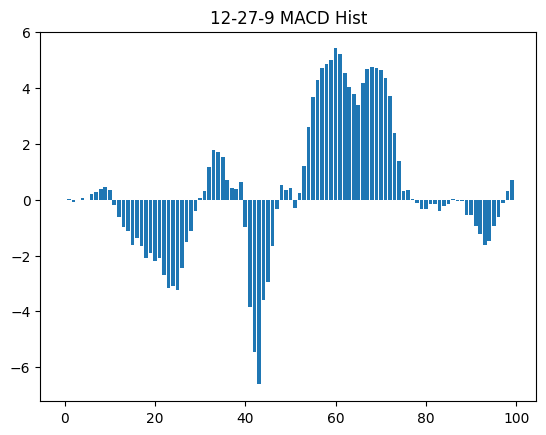

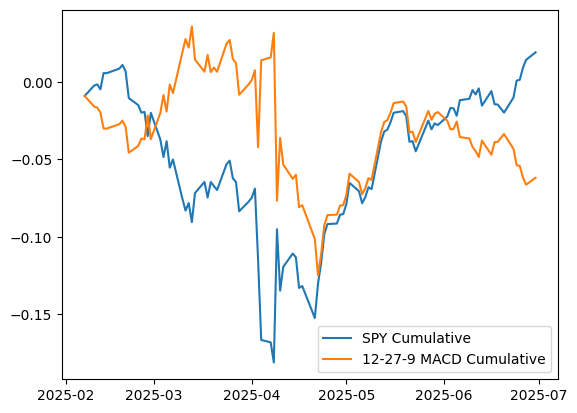

In [ ]:
# MACD - when fast signal crosses above MACD line suggests bullish momentum, when signal below MACD is bearish

TICKER = 'SPY'
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
LOOKBACK = 100


def get_data(ticker=TICKER, lookback=LOOKBACK):
    df = yf.download(
        ticker,
        start='1993-01-29',
        end='2025-07-01',
        interval='1d',
        auto_adjust=False,
        progress=False,
        threads=False
    )
    return df.dropna().iloc[-lookback:, :]


def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema '] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema '] = df['Close'].ewm(span=slow).mean()

    

    # macd line is diff between fast and slow (exp)
    df[f'MACD'] = df[f'{fast}_ema '] - df[f'{slow}_ema ']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    df['MACD_hist'] = df['MACD'] - df['Signal']


    plt.bar(x=range(len(df)),height=df['MACD_hist'])
    plt.title(f'{MACD_FAST}-{MACD_SLOW}-{MACD_SPAN} MACD Hist')

    return df


def add_strategy(df):
    df.columns = df.columns.get_level_values(0)

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['MACD_hist'] > 0, 1,-1)
    df['Strategy'] = df['Strategy'].shift(1)

    return df.dropna()


def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change()*df['Strategy']).cumprod() - 1
    
    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative',f'{MACD_FAST}-{MACD_SLOW}-{MACD_SPAN} MACD Cumulative' ])

    return df.dropna()


def main():
    df = get_data()
    df = add_MACD(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df


df = main()
df